[Reference](https://medium.com/@manoochehr1364/converting-insights-from-a-shap-summary-plot-into-a-pandas-dataframe-a21dfd20f8eb)

# Importing python libraries


In [5]:
!pip install shap

     |████████████████████████████████| 564 kB 21.4 MB/s 


In [6]:
import pandas as pd
import shap
import numpy as np
import sklearn
from sklearn.model_selection  import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
import altair as alt
import matplotlib.pyplot as plt
import scipy

# Data Preparation


In [7]:
X,y = shap.datasets.boston()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
477,15.02340,0.0,18.10,0.0,0.6140,5.304,97.3,2.1007,24.0,666.0,20.2,349.48,24.91
15,0.62739,0.0,8.14,0.0,0.5380,5.834,56.5,4.4986,4.0,307.0,21.0,395.62,8.47
332,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83
423,7.05042,0.0,18.10,0.0,0.6140,6.103,85.1,2.0218,24.0,666.0,20.2,2.52,23.29
19,0.72580,0.0,8.14,0.0,0.5380,5.727,69.5,3.7965,4.0,307.0,21.0,390.95,11.28


# Prediction Model Training (XGBoost regressor)


In [8]:
xgb_reg = xgb.XGBRegressor(n_estimators=20)
xgb_reg.fit(X_train,y_train);
print("Training R2 Score: ",r2_score(y_train,xgb_reg.predict(X_train)))
print("Testing R2 Score: ",r2_score(y_test,xgb_reg.predict(X_test)))

[10:54:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R2 Score:  0.7940392815935429
Testing R2 Score:  0.7153681308905229


# Plotting Truth versus Prediction for Training and Testing Set


In [9]:
results=pd.concat([pd.DataFrame({"Truth":y_train,"Prediction":xgb_reg.predict(X_train),"Set":["Training"]*len(y_train)}),
          pd.DataFrame({"Truth":y_test,"Prediction":xgb_reg.predict(X_test),"Set":["Testing"]*len(y_test)})])
alt.Chart(results).mark_circle(size=100).encode(x='Truth',
                                                y='Prediction',
                                                color='Set',
                                                tooltip=['Truth', 'Prediction', 'Set']).properties(width=800,
                                                                                                   height=400,
                                                                                                   title=alt.TitleParams(['Training R2 Score : {0}'.format(r2_score(y_train,xgb_reg.predict(X_train))),
                                                                                                                          'Testing R2 Score : {0}'.format(r2_score(y_test,xgb_reg.predict(X_test)))],
                                                                                                                         baseline='bottom',
                                                                                                                         orient='bottom',
                                                                                                                         anchor='end',
                                                                                                                         fontWeight='normal',
                                                                                                                         fontSize=12)).interactive()

alt.Chart(...)

# SHAP Summary Plot


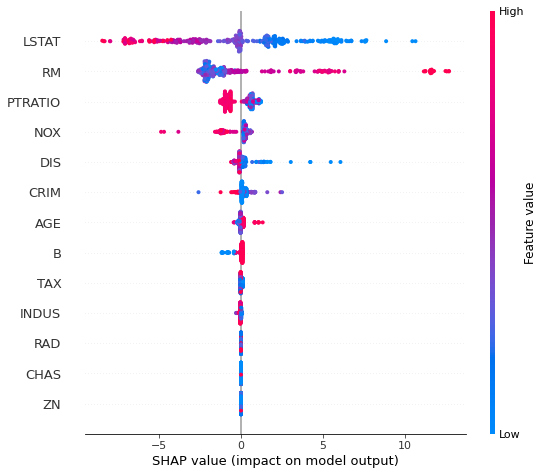

In [10]:
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_train)
fig = plt.figure(figsize=(30, 30))
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns,show=False)
plt.tight_layout()

# Converting Insights from SHAP Summary Plot into a Pandas DataFrame


In [11]:
def Pos_Neg(x):
    try:
        if x>0:
            return "High"
        elif x<0:
            return "Low"
        else:
            return "Neutral"
    except:
        return None
    
def general_normalizer(x,data_scale,target_scale):
    try:
        return (target_scale[1]-target_scale[0])*((x-data_scale[0])/(data_scale[1]-data_scale[0]))+target_scale[0]
    except:
        return None
def sign_function(x):
    try:
        if x>0:
            return 1
        elif x<0:
            return -1
        else:
            return 0
    except:
        return None
def shannon(a_list):
    return scipy.stats.entropy(pd.Series(a_list).value_counts())
def extract_shap_insights(df_shap,df_features):
    
    df_shap=df_shap.reset_index(drop=True)
    df_features=df_features.reset_index(drop=True)
    
    df_shap=df_shap.rename(columns=dict(zip(df_shap.columns.tolist(),["shap_"+c for c in df_shap.columns.tolist()])))
    df_features=df_features.rename(columns=dict(zip(df_features.columns.tolist(),["feature_"+c for c in df_features.columns.tolist()])))
    
    for c in df_features.columns:
        min_c=df_features[c].min()
        max_c=df_features[c].max()
        df_features[c]=df_features[c].apply(lambda x: general_normalizer(x,[min_c,max_c],[-1,1]))
    
    concated_shap=pd.concat([df_shap,df_features],axis=1)
    
    
    SHAP_columns=list(set([c.replace("shap_","").replace("feature_","") for c in concated_shap.columns]))
    SHAP=pd.DataFrame(index=SHAP_columns,columns=["relative_impact","upgrading_impact","upgrading_impurity","downgrading_impact","downgrading_impurity"])
    
    for ind in SHAP.index:
        SHAP.loc[ind,"relative_impact"]=concated_shap["shap_"+ind].abs().mean()
        shap_ind="shap_"+ind
        feat_ind="feature_"+ind
        sign_feat="sign_"+ind
        temp_data=concated_shap[[shap_ind,feat_ind]].copy()
        temp_data["product"]=temp_data[shap_ind].abs()*temp_data[feat_ind]
        temp_data[sign_feat]=temp_data[feat_ind].apply(lambda x: sign_function(x))
        SHAP.loc[ind,"upgrading_impact"]=temp_data[temp_data[shap_ind]>0]["product"].sum()
        SHAP.loc[ind,"upgrading_impurity"]=shannon(temp_data[temp_data[shap_ind]>0][sign_feat])
        SHAP.loc[ind,"downgrading_impact"]=temp_data[temp_data[shap_ind]<0]["product"].sum()
        SHAP.loc[ind,"downgrading_impurity"]=shannon(temp_data[temp_data[shap_ind]<0][sign_feat])
        del temp_data
    
    SHAP["feature_direction_for_upgrading"]=SHAP["upgrading_impact"].apply(lambda x: Pos_Neg(x))
    SHAP["feature_direction_for_downgrading"]=SHAP["downgrading_impact"].apply(lambda x: Pos_Neg(x))
    SHAP["upgrading_impact"]=SHAP["upgrading_impact"].abs()
    SHAP["downgrading_impact"]=SHAP["downgrading_impact"].abs()
    
    SHAP=SHAP[['relative_impact', 'upgrading_impact', 'feature_direction_for_upgrading','upgrading_impurity','downgrading_impact', 'feature_direction_for_downgrading','downgrading_impurity']]
    
    SHAP=SHAP.sort_values(by="relative_impact",ascending=False)
    
    return SHAP
shap_values_df=pd.DataFrame(shap_values,columns=X_train.columns.tolist())
extract_shap_insights(shap_values_df,X_train)

,relative_impact,upgrading_impact,feature_direction_for_upgrading,upgrading_impurity,downgrading_impact,feature_direction_for_downgrading,downgrading_impurity
LSTAT,3.055498,472.033612,Low,0.0,71.112078,High,0.589615
RM,2.571415,271.346472,High,0.0,71.332774,Low,0.601531
PTRATIO,0.71529,20.211085,Low,0.689408,87.309729,High,0.0
NOX,0.468291,39.651438,Low,0.224733,45.751856,High,0.0
DIS,0.238822,57.323765,Low,0.065214,5.313486,Low,0.502724
CRIM,0.188949,60.96412,Low,0.0,3.395715,Low,0.348832
AGE,0.114148,26.856977,High,0.0,1.003533,Low,0.690553
B,0.106559,18.777521,High,0.06276,14.53312,Low,0.693147
TAX,0.041701,5.8381,Low,0.0,1.491057,Low,0.643822
INDUS,0.037475,1.771782,Low,0.0,0.485566,High,0.667432
